# Create a Realistic Elliptical Galaxy with Multiple Photometry Component 

* The model is based on results from Huang et al. (2013a)

In [34]:
%matplotlib inline 
from __future__ import (division, print_function, absolute_import,
                        unicode_literals)

import os
import re
import json
import warnings
import subprocess

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.patches import Ellipse

# Numpy 
import numpy as np 
import numpy.random as rand

# GalSim
import galsim
print("# GalSim version : ", galsim.__version__)

# Numba
import numba 
from numba import jit
print("# Numba version : ", numba.__version__)

# PyMultiNest
import pymultinest
print("# PyMultiNest version : ", pymultinest.__path__)

# emcee 
import emcee 
print("# emcee version : ", emcee.__version__)

# PyMC3 
import pymc3 
print("# PyMC3 version : ", pymc3.__version__)

# Corner
import corner 
print("# Corner version : ", corner.__version__)

# Color Map
from palettable.colorbrewer.qualitative import Set1_9 as compColor
try:
    cmap1 = plt.get_cmap('viridis')
    cmap1.set_bad('k', 1.)
    cmap2 = plt.get_cmap('inferno')
    cmap2.set_bad('w', 1.)
except Exception:
    from palettable.cubehelix import Cubehelix
    cmap1 = Cubehelix.make(start=0.3, rotation=-0.5,
                          reverse=True).mpl_colormap
    cmap1.set_bad('k', 1.)
    cmap2 = Cubehelix.make(start=0.5, rotation=-1.5,
                           gamma=1.0, sat=1.2,
                           min_light=0.,
                           max_light=1.).mpl_colormap
    cmap2.set_bad('w', 1.)

# GalSim version :  1.4
# Numba version :  0.27.0
# PyMultiNest version :  ['/usr/local/lib/python2.7/site-packages/pymultinest-1.6-py2.7.egg/pymultinest']
# emcee version :  2.2.1
# PyMC3 version :  3.0
# Corner version :  2.0.2.dev0


In [35]:
def zscale(img, contrast=0.25, samples=500):
    """
    Image scaling function.

    form http://hsca.ipmu.jp/hscsphinx/scripts/psfMosaic.html
    """
    ravel = img.ravel()
    ravel = ravel[np.isfinite(ravel)]

    if len(ravel) > samples:
        imsort = np.sort(np.random.choice(ravel, size=samples))
    else:
        imsort = np.sort(ravel)

    n = len(imsort)
    idx = np.arange(n)

    med = imsort[int(n / 2)]
    w = 0.25
    i_lo, i_hi = int((0.5 - w) * n), int((0.5 + w) * n)
    # BUG: Sometimes the polyfit could fail
    try:
        p = np.polyfit(idx[i_lo:i_hi], imsort[i_lo:i_hi], 1)
        slope, intercept = p
    except Exception:
        slope = 1.0

    z1 = med - (slope/contrast)*(n/2-n*w)
    z2 = med + (slope/contrast)*(n/2-n*w)

    return z1, z2

@jit
def galsimSersic(flux, reff, nser, q, pa, imgX, imgY, 
                 psf=None, scale=1.0, exptime=None, 
                 trunc=0):
    ser = galsim.Sersic(nser, 
                        half_light_radius=reff, 
                        trunc=trunc).shear(q=q, 
                                           beta=(0.0*
                                                 galsim.degrees)).rotate((90.0-pa)*
                                                                             galsim.degrees).withFlux(flux)
    if exptime is not None:
        ser *= exptime
        
    if psf is not None: 
        gal = galsim.Convolve([ser, psf])
    else: 
        gal = ser
        
    return (ser.drawImage(galsim.image.Image(imgX, imgY), 
                          method='no_pixel', scale=scale)).array
    

@jit(nopython=True, cache=True)
def loglike(model, data, sigma):
    """Get the log(Likelihood)."""
    return np.nansum(((-0.5) * ((model - data) / sigma) ** 2))

def loglike_old(model, data, sigma):
    """Get the log(Likelihood)."""
    return ((-0.5) * ((model - data) / sigma) ** 2).sum()

@jit(nopython=True, cache=True)
def logmad(model, data): 
    """
    Using MAD: Median absolute deviation.
    https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    return ((-0.5) * (1.4826 * np.nanmedian(np.abs((model - data) - np.nanmedian(model - data)))) ** 2)

def logmad_old(model, data): 
    """
    Using MAD: Median absolute deviation.
    https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    return ((-0.5) * (1.4826 * np.nanmedian(np.abs((model - data) - np.nanmedian(model - data)))) ** 2)

@jit(nopython=True, cache=True)
def mag2Flux(mag, zp, exptime):
    """Convert magnitude into flux"""
    return (10.0 ** ((zp - mag) / 2.5)) * exptime

def mag2Flux_old(mag, zp, exptime):
    """Convert magnitude into flux"""
    return (10.0 ** ((zp - mag) / 2.5)) * exptime

""" From Ben Johnson's Prospector: priors.py"""
def tophat(theta, mini=0.0, maxi=1.0, **extras):
    """
    A simple tophat function.  Input can be scalar or matched vectors
    """
    lnp = 1.0 * np.zeros_like(theta)
    n = (theta < mini) | (theta > maxi)
    lnp[n] = -np.infty
    return lnp

def normal(theta, mean=0.0, sigma=1.0, **extras):
    """
    A simple gaussian.  should make sure it can be vectorized.
    """
    return np.log((2*np.pi)**(-0.5)/sigma) - (theta - mean)**2/(2*sigma**2)

## Benchmark 

In [3]:
# With @jit
%timeit -n 1000 mag2Flux(23.0, 25.94, 100.0)

The slowest run took 15.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 245 ns per loop


In [4]:
# Without @jit
%timeit -n 1000 mag2Flux_old(23.0, 25.94, 100.0)

1000 loops, best of 3: 681 ns per loop


In [3]:
# Fake large 2-D array
mm = rand.random_sample([2000, 2000]) * 10.0
dd = rand.random_sample([2000, 2000]) * 10.0 
ss = rand.random_sample([2000, 2000]) * 0.5 

In [4]:
%timeit -n10 loglike(mm, dd, ss)

10 loops, best of 3: 34.8 ms per loop


In [8]:
%timeit -n10 loglike_old(mm, dd, ss)

10 loops, best of 3: 57.6 ms per loop


In [9]:
%timeit -n10 logmad(mm, dd)

10 loops, best of 3: 172 ms per loop


In [10]:
%timeit -n10 logmad_old(mm, dd)

10 loops, best of 3: 203 ms per loop


# Simple test using COSMOS galaxies

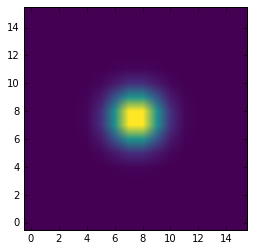

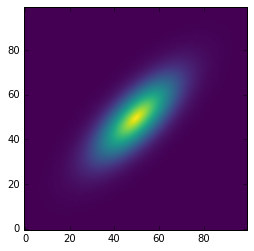

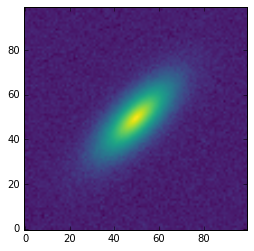

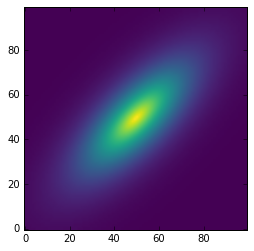

-0.383008351411 30.3224633005
5.32861e-05 5.50609


In [37]:
# Based on example provided by COSMOSCatalog() reference page

# 
im_size = 100 
pix_scale = 0.05 
zp = 25.94 
exptime = 200.0

# Test model
mag_true = 22.5
reff_true = 0.4
nser_true = 1.0 
q_true = 0.4
pa_true = 45.0

# PSF model
psf = galsim.Gaussian(fwhm=2.0)

plt.imshow((psf.drawImage()).array, origin='lower', cmap=cmap1)
plt.show()

# Sersic galaxy model
galaxy = galsimSersic(mag2Flux(mag_true, zp, 1.0), reff_true, 
                      nser_true, q_true, pa_true, 
                      im_size, im_size, psf=psf, scale=pix_scale, 
                      exptime=exptime, trunc=0)

plt.imshow(np.arcsinh(galaxy), origin='lower', cmap=cmap1)
plt.show()

# Image with noise
data = galaxy + np.random.normal(0.0, 0.1, [im_size, im_size])

plt.imshow(np.arcsinh(data), origin='lower', cmap=cmap1)
plt.show()

# Sigma image
sigma = np.sqrt(galaxy + 1e-10)

plt.imshow(np.arcsinh(sigma), origin='lower', cmap=cmap1)
plt.show()

print(np.min(data), np.max(data))
print(np.min(sigma), np.max(sigma))

### Benchmark

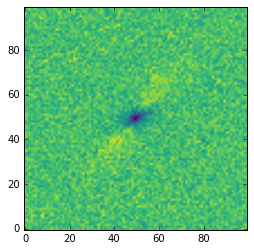

1.85935e-09 29.2921


In [39]:
test = galsimSersic(mag2Flux(22.5, 25.94, 1.0), 0.405, 0.99, 0.39, 44.5, 
                    im_size, im_size, psf=psf, scale=pix_scale, 
                    exptime=exptime, trunc=0)

plt.imshow(np.arcsinh(test - data), origin='lower', cmap=cmap1)
plt.show()

print(np.nanmin(test), np.nanmax(test))

In [40]:
# Very slow...
%timeit -n10 galsimSersic(mag2Flux(20.0, 25.94, 1.0), 5.32, 4.7, 0.30, -27.0, 1000, 1000, psf=psf, trunc=8, scale=pix_scale, exptime=exptime)

10 loops, best of 3: 15 ms per loop


## MultiNest Test

In [41]:
# Number of free parameters in single Sersic model 
parameters = ["mag", "reff", "nser", "q", "pa"]
n_params = len(parameters)

# Model 
def model(mag, reff, nser, q, pa,
          imgX=64, imgY=64, scale=1.0, 
          psf=None, zp=25.94, exptime=None,
          trunc=10):
    """Single Sersic model."""
    if nser > 3.5:
        return galsimSersic(mag2Flux(mag, zp, 1.0), reff, nser, q, pa, 
                            imgX, imgY, psf=psf, 
                            scale=pix_scale,
                            exptime=exptime,
                            trunc=trunc)
    else:
        return galsimSersic(mag2Flux(mag, zp, 1.0), reff, nser, q, pa, 
                            imgX, imgY, psf=psf, 
                            scale=pix_scale,
                            exptime=exptime,
                            trunc=0)

    
# Priors
def prior(cube, n_dim, n_params):
    """Priors for single Sersic models."""
    # Magnitude
    cube[0] = cube[0] * 4.0 + 20.0
    # Effective radius
    cube[1] = cube[1] * 1.1 + 0.02 
    # Sersic index
    cube[2] = cube[2] * 2.5 + 0.5
    # Axie ratio  
    cube[3] = cube[3] * 0.95 + 0.05
    # Position angle
    cube[4] = cube[4] * 180.0
    
    
# Log Likelihood
def logliklihood(cube, n_dim, n_params):
    """Log(Likelihood)."""
    mag, reff, nser, q, pa = cube[0], cube[1], cube[2], cube[3], cube[4]
    
    return loglike(model(mag, reff, nser, q, pa,
                         imgX=im_size, 
                         imgY=im_size, 
                         scale=pix_scale, 
                         psf=psf, zp=zp, 
                         exptime=exptime), 
                   data, sigma)

In [42]:
%timeit -n100 model(22.0, 1.0, 2.0, 0.5, 45.0, imgX=100, imgY=100, scale=0.05, psf=psf, zp=25.94, exptime=200)

100 loops, best of 3: 1.04 ms per loop


In [43]:
%timeit -n100 loglike(model(22.0, 1.0, 2.0, 0.5, 45.0, imgX=100, imgY=100, scale=0.05, psf=psf, zp=25.94, exptime=200), data, sigma)

The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.13 ms per loop


  analysing data from sersic_test_1_.txt


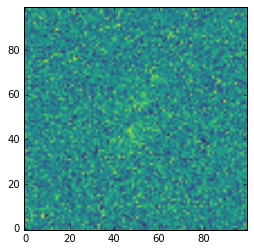

In [44]:
# Run multinest
pymultinest.run(logliklihood, prior, n_params, 
                outputfiles_basename='sersic_test_1_', 
                importance_nested_sampling=True, 
                const_efficiency_mode=False, 
                n_live_points=500, 
                evidence_tolerance=0.5, 
                sampling_efficiency=0.8,
                n_iter_before_update=100, 
                null_log_evidence=-1e+90,
                max_modes=100, 
                mode_tolerance=-1e+90, 
                max_iter=0, 
                init_MPI=True,
                resume=False, 
                verbose=True)

# Dump the parameter names 
json.dump(parameters, open('sersic_test_1_params.json', 'w'))

# Load in the results
res = pymultinest.Analyzer(outputfiles_basename='sersic_test_1_', 
                           n_params = n_params)

# Best parameters
bestP = res.get_best_fit()['parameters']

# Get the best models
bestM = galsimSersic(mag2Flux(bestP[0], zp, 1.0), bestP[1], bestP[2], 
                     bestP[3], bestP[4], im_size, im_size, 
                     psf=psf, scale=pix_scale, exptime=200.0)

# Show the residual
plt.imshow(np.arcsinh(bestM - data), origin='lower', cmap=cmap1)
plt.show()

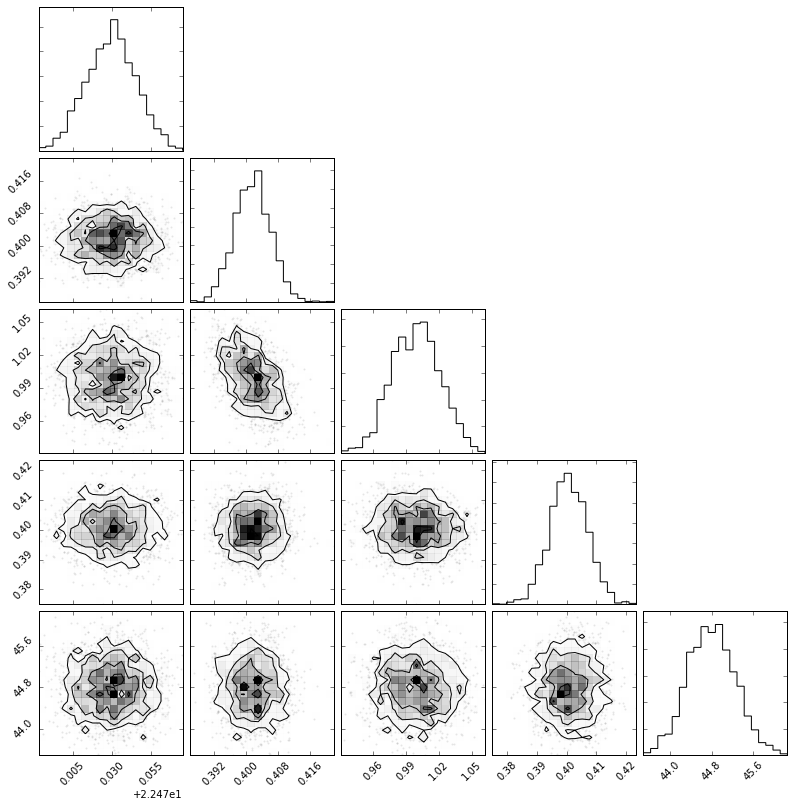

In [45]:
# Corner plot
figure = corner.corner(res.get_equal_weighted_posterior()[:,0:5])